## Import packages

In [ ]:
import torch
import numpy as np
import time
from scipy.ndimage import distance_transform_edt as distance
from scipy.ndimage import _nd_image

In [ ]:
device = torch.device("cuda:0")
print(device)

cuda:0


# Loss Functions

In [ ]:
def dice_loss(score, target):
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target * target)
    z_sum = torch.sum(score * score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    loss = 1 - loss
    return loss



In [ ]:
def hd_loss(seg_soft, gt, seg_dtm, gt_dtm):
    """
    compute huasdorff distance loss for binary segmentation
    input: seg_soft: softmax results,  shape=(b,2,x,y,z)
           gt: ground truth, shape=(b,x,y,z)
           seg_dtm: segmentation distance transform map; shape=(b,2,x,y,z)
           gt_dtm: ground truth distance transform map; shape=(b,2,x,y,z)
    output: boundary_loss; sclar
    """

    delta_s = (seg_soft - gt) ** 2
    s_dtm = seg_dtm ** 2
    g_dtm = gt_dtm ** 2
    dtm = s_dtm + g_dtm
    multipled = torch.einsum('xy, xy->xy', delta_s, dtm)
    hd_loss = multipled.mean()

    return hd_loss

# Benchmarks

In [ ]:
hd_mean = []
hd_std = []
	
dice_mean = []
dice_std = []
	
hd_GPU_mean = []
hd_GPU_std = []
	
dice_GPU_mean = []
dice_GPU_std = []

hd_times = []
dice_times = []
hd_GPU_times = []
dice_GPU_times = []

In [ ]:
for n in range(1,1000,100):
  # HD CPU
  temp_hd_time = []
  for i in range(100): #Samples
    a = []
    for j in range(10): #Evaluations
      times1 = time.time()
      x1 = torch.randint(0,1,(n,n))
      tfm1 = torch.from_numpy(distance(x1))
      hd = hd_loss(x1, x1, tfm1, tfm1)
      a.append(time.time()-times1)
    temp_hd_time.append(torch.mean(torch.FloatTensor(a)))
  hd_times.append(temp_hd_time)

for n in range(1,1000,100):
  # Dice CPU
  temp_dice_time = []
  for i in range(100): #Samples
    b = []
    for j in range(10): #Evaluations
      times2 = time.time()
      x2 = torch.randint(0,1,(n,n))
      dice = dice_loss(x2, x2)
      b.append(time.time()-times2)
    temp_dice_time.append(torch.mean(torch.FloatTensor(b)))
  dice_times.append(temp_dice_time)
  
for n in range(1,1000,100):
  # HD GPU
  temp_hd_GPU_time = []
  for i in range(100): #Samples
    c = []
    for j in range(10): #Evaluations
      times3 = time.time()
      x3 = torch.randint(0,1,(n,n)).to(device)
      tfm3 = torch.from_numpy(distance(x3.cpu().numpy())).to(device)
      hd_gpu = hd_loss(x3, x3, tfm3, tfm3)
      c.append(time.time()-times3)
    temp_hd_GPU_time.append(torch.mean(torch.FloatTensor(c)))
  hd_GPU_times.append(temp_hd_GPU_time)

for n in range(1,1000,100):
  # Dice GPU
  temp_dice_GPU_time = []
  for i in range(100): #Samples
    d = []
    for j in range(10): #Evaluations
      times4 = time.time()
      x4 = torch.randint(0,1,(n,n)).to(device)
      dice_gpu = dice_loss(x4, x4)
      d.append(time.time()-times4)
    temp_dice_GPU_time.append(torch.mean(torch.FloatTensor(d)))
  dice_GPU_times.append(temp_dice_GPU_time)


In [ ]:
for i in hd_times:
  hd_mean.append(torch.mean(torch.FloatTensor(i)).numpy().tolist())
  hd_std.append(torch.std(torch.FloatTensor(i), unbiased = False).numpy().tolist())

In [ ]:
for i in dice_times:
  dice_mean.append(torch.mean(torch.FloatTensor(i)).numpy().tolist())
  dice_std.append(torch.std(torch.FloatTensor(i), unbiased = False).numpy().tolist())

In [ ]:
for i in hd_GPU_times:
  hd_GPU_mean.append(torch.mean(torch.FloatTensor(i)).numpy().tolist())
  hd_GPU_std.append(torch.std(torch.FloatTensor(i), unbiased = False).numpy().tolist())

In [ ]:
for i in dice_GPU_times:
  dice_GPU_mean.append(torch.mean(torch.FloatTensor(i)).numpy().tolist())
  dice_GPU_std.append(torch.std(torch.FloatTensor(i), unbiased = False).numpy().tolist())

### Save

In [ ]:
import pandas as pd

In [ ]:
hd_mean = np.array(hd_mean)
dice_mean = np.array(dice_mean)
hd_GPU_mean = np.array(hd_GPU_mean)
dice_GPU_mean = np.array(dice_GPU_mean)
hd_std = np.array(hd_std)
dice_std = np.array(dice_std)
hd_GPU_std = np.array(hd_GPU_std)
dice_GPU_std = np.array(dice_GPU_std)

In [ ]:
data = {'hd_mean': hd_mean, 'dice_mean': dice_mean, 'hd_GPU_mean': hd_GPU_mean, 'dice_GPU_mean': dice_GPU_mean, 'hd_std': hd_std, 'dice_std': dice_std, 'hd_GPU_std': hd_GPU_std, 'dice_GPU_std':dice_GPU_std}

In [ ]:
dataframe = pd.DataFrame(data)

In [ ]:
dataframe.to_csv('Loss_Timing_Python.csv')

In [ ]:
dataframe

,hd_mean,dice_mean,hd_GPU_mean,dice_GPU_mean,hd_std,dice_std,hd_GPU_std,dice_GPU_std
0,0.000414,0.000070,0.009859,0.000250,0.001562,0.000097,0.094716,0.000108
1,0.001365,0.000283,0.001329,0.000446,0.000370,0.000037,0.000078,0.000054
2,0.004755,0.001019,0.004536,0.001034,0.000257,0.000070,0.000209,0.000057
3,0.009938,0.002187,0.009435,0.001876,0.000275,0.000112,0.000227,0.000083
4,0.016855,0.003641,0.016325,0.003110,0.000400,0.000126,0.000318,0.000106
5,0.026373,0.005585,0.025492,0.004537,0.000579,0.000169,0.000563,0.000142
6,0.038447,0.007803,0.035539,0.006407,0.001174,0.000257,0.000703,0.000159
7,0.050760,0.010425,0.049855,0.008618,0.001232,0.000272,0.001128,0.000225
8,0.069294,0.013713,0.066297,0.011146,0.001422,0.000308,0.001001,0.000191
9,0.089041,0.018029,0.082119,0.013757,0.002001,0.000543,0.002724,0.000306


In [ ]:
x = [i for i in range(1, 1000, 100)]

In [ ]:
import matplotlib.pyplot as plt


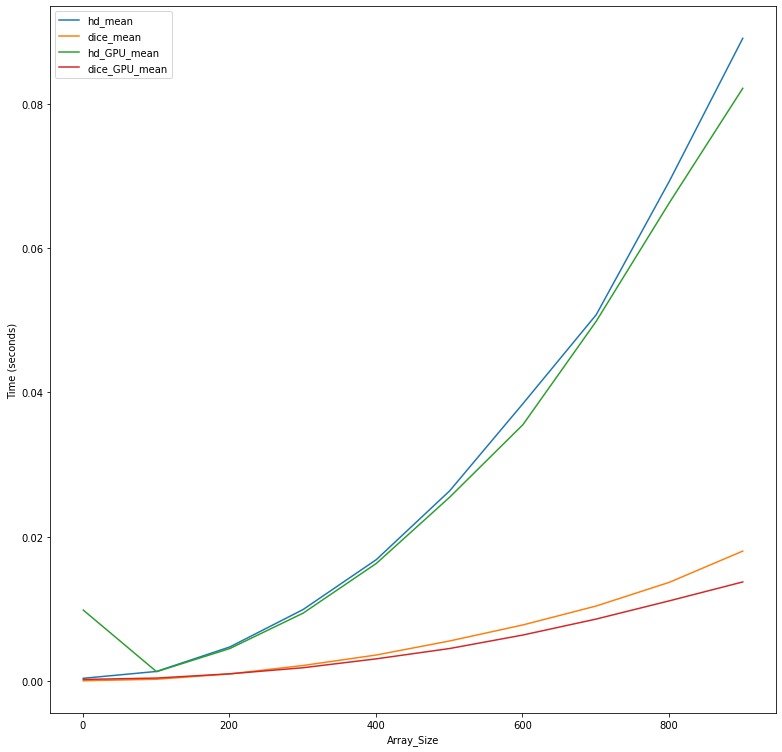

In [ ]:
plt.figure(figsize=(13, 13))
plt.plot(x, dataframe['hd_mean'], label = 'hd_mean')
plt.plot(x, dataframe['dice_mean'], label = 'dice_mean')
plt.plot(x, dataframe['hd_GPU_mean'], label = 'hd_GPU_mean')
plt.plot(x, dataframe['dice_GPU_mean'], label = 'dice_GPU_mean')
plt.xlabel('Array_Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()